In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model

In [2]:
df_modelling_set = pd.read_csv('../1.data-preparation/processed-data/modelling_data.csv')

# I. Examine Target Variable - Days in Hospital

- Most members (84.7%) do not stay in hospitals in Y2 and Y3
- The majority of those who have to go to the hospital only stay there for a few days (below 5 days)

In [7]:
df_modelling_set['DaysInHospital'].describe()

count    147473.000000
mean          0.452951
std           1.573818
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: DaysInHospital, dtype: float64

In [37]:
d = dict(df_modelling_set['DaysInHospital'].value_counts())

total = df_modelling_set['DaysInHospital'].count()

for key in d:
    d[key] = [d[key], d[key]/total*100]

df_dih_value_distribution = pd.DataFrame.from_dict(d, orient='index')
df_dih_value_distribution.columns = ['count', 'percentage']
df_dih_value_distribution.sort_index()

,count,percentage
0,124975,84.744326
1,9299,6.305561
2,4548,3.083954
3,2882,1.954256
4,1819,1.233446
5,1093,0.741153
6,660,0.447540
7,474,0.321415
8,316,0.214277
9,263,0.178338


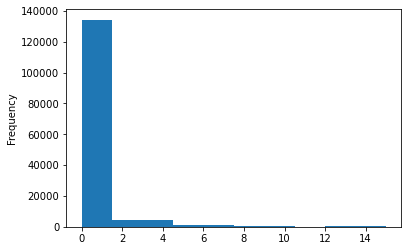

In [8]:
df_modelling_set['DaysInHospital'].plot.hist()

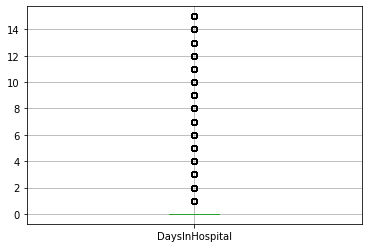

In [100]:
df_modelling_set.boxplot(column = ['DaysInHospital'])

# II. Examine Relationships

In [57]:
# Generate correlation matrix

def generate_correlation_matrix(df, corr_method):
    return df.corr(method=corr_method)

corr_matrix = generate_correlation_matrix(df_modelling_set, 'pearson')
corr_series = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending= False)

In [58]:
corr_series.to_csv('corr_matrix.csv')

## A. Correlation between Target Variable and Features

Below are the top 20 features that have the highest correlation with our target variable **DaysInHospital** 

We can categorize these 20 variables into 2 groups:
- Group 1 represents the **general** medical need of the patient in the previous year. This group consists of variables such as: previous year number of claims, previous year number of primary condition groups, Charlson Index - which indicates how severe the conditions were, amount of drug consumed, etc. Generally, the higher the demand for medical service this year, the more likely one is going into the hospital the following year, which is totally intuitive.

- Group 2 gives us much more insight as it represents the **specific** setups that most likely results in future admission to hospital. For example, those who have undergone PG2 (Evaluation and Management Procedure Group) or SP2 (Internal Specialty) or SP6 (Diagnostic Imaging Specialty) or PS1 (Office Place of Service) are much more likely to have to stay in the hospital in the following year 

In [87]:
top_corr_with_target = corr_series['DaysInHospital'][1:21]

In [88]:
top_corr_with_target

no_Claims                    0.191123
DSFS_sum                     0.188009
LOS_TOT_UNKNOWN_count        0.186740
pg2                          0.180604
no_Providers                 0.178688
no_PrimaryConditionGroups    0.175970
no_Vendors                   0.173839
PayDelay_sum                 0.168304
ClaimsTruncated              0.164787
DrugCount_sum                0.155028
sp2                          0.152889
CharlsonIndex_max            0.152187
DrugCount_max                0.144863
sp6                          0.143976
LabCount_sum                 0.142285
CharlsonIndex_mean           0.141432
ps1                          0.141357
no_PlaceSvcs                 0.140371
DrugCount_mean               0.137459
no_Specialties               0.137277
dtype: float64

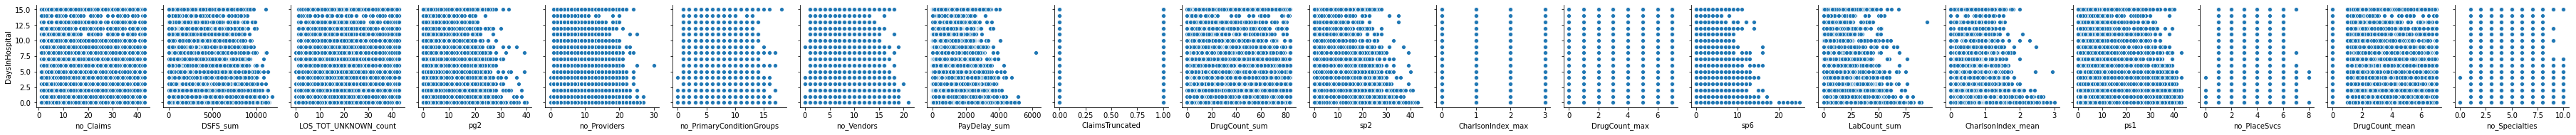

In [98]:
g = sns.pairplot(df_modelling_set, 
                 x_vars=list(top_corr_with_target.index),
                 y_vars= ['DaysInHospital'])

plt.show()

## B. Relationships between No of Claims and Specific Conditions 

As previous year no_Claims seems to have strong predictive power over our Target variable, we would want to see the relationships between this variable and other condition-specific variables. 

Result:
- 3 specialties with the most claims: Internal, Laboratory, General Practice
- 3 places of service with the most claims: Office, Independent Lab, Urgent Care
- 3 primary condition groups with the most claims: MSC2a3, METAB3, ARTHSPIN
- 3 primary procedure groups with the most claims: EM, PL, MED
- For Charlson Index which indicates the patient's condition severity, 97% of claiming patients fall into the index range of 0-2, which means most people do not get lethal conditions 

In [101]:
df_claims = pd.read_csv('../data/Claims.csv')

In [139]:
def examine_claims_and(var, limit=-1):
    df_claims_by_specialty = df_claims.groupby(var).agg({'MemberID': 'count'})
    df_claims_by_specialty.columns = ['No_claims']    
    total_claims = df_claims_by_specialty['No_claims'].sum()
    df_claims_by_specialty['percentage'] = df_claims_by_specialty['No_claims']/total_claims*100
    df_claims_by_specialty = df_claims_by_specialty.sort_values(['percentage'], ascending = False)
    if limit == -1:
        df_claims_by_specialty.plot.bar(y='No_claims')
    else:
        df_claims_by_specialty[:limit].plot.bar(y='No_claims')
    display(df_claims_by_specialty)

### 1. No of Claims and Specialty

,No_claims,percentage
Specialty,,
Internal,672059,25.259821
Laboratory,653188,24.550541
General Practice,473655,17.802664
Surgery,208217,7.825986
Diagnostic Imaging,207297,7.791407
Emergency,126130,4.740687
Other,92687,3.483708
Pediatrics,84862,3.189599
Rehabilitation,57554,2.163208


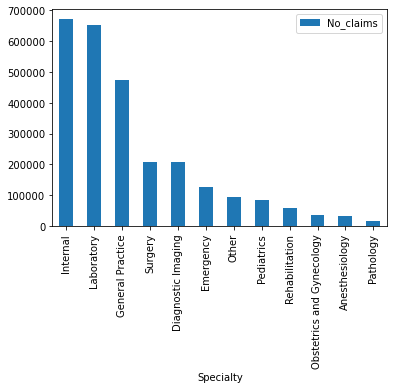

In [140]:
examine_claims_and('Specialty')

### 2. No of Claims and Place of Service

,No_claims,percentage
PlaceSvc,,
Office,1542007,57.940608
Independent Lab,657750,24.714826
Urgent Care,199528,7.497225
Outpatient Hospital,121528,4.566391
Inpatient Hospital,85776,3.223016
Ambulance,34766,1.306326
Other,11700,0.439625
Home,8303,0.311984


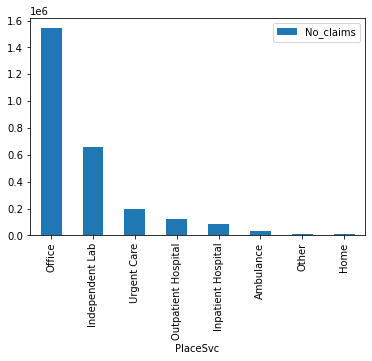

In [141]:
examine_claims_and('PlaceSvc')

### 3. No of Claims and Primary Condition Group

,No_claims,percentage
PrimaryConditionGroup,,
MSC2a3,507277,19.087930
METAB3,320553,12.061838
ARTHSPIN,288285,10.847651
NEUMENT,171605,6.457190
RESPR4,138062,5.195027
MISCHRT,131047,4.931065
SKNAUT,107976,4.062944
GIBLEED,101846,3.832284
INFEC4,83552,3.143913


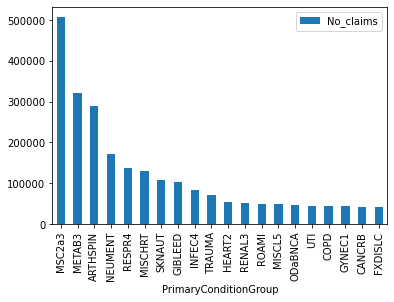

In [144]:
examine_claims_and('PrimaryConditionGroup', limit = 20)

### 4. No of Claims and Charlson Index

,No_claims,percentage
CharlsonIndex,,
0,1356995,50.843016
1-2,1256527,47.078745
3-4,49479,1.853847
5+,5989,0.224392


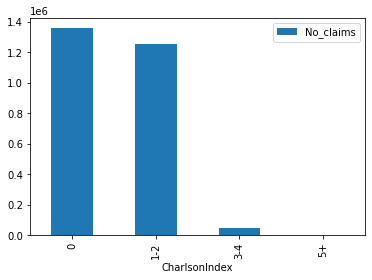

In [145]:
examine_claims_and('CharlsonIndex')

### 5. No of Claims and Procedure Group 

,No_claims,percentage
ProcedureGroup,,
EM,1048210,39.327809
PL,492919,18.493837
MED,372101,13.960864
SCS,274805,10.310414
RAD,265272,9.952745
SDS,60678,2.276579
SIS,56461,2.118361
SMS,29177,1.094692
ANES,17061,0.640112


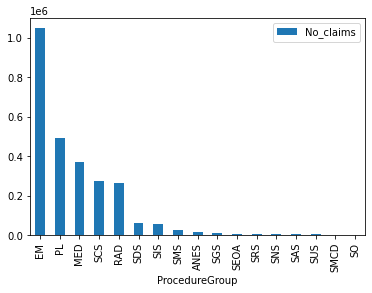

In [146]:
examine_claims_and('ProcedureGroup')

# III. Examine Other Important Variables

## A. Claims per Member in Year 1

Excluding those who make no claims, the distribution of no of claims per member resembles a long-tailed distribution with long right tail:
- Half of the claimants make less than 8 claims
- Still, 35% of the claiming members make at least 12 claims per year, which means at least 1 claim every month

In [163]:
df_modelling_set_y1 = df_modelling_set[df_modelling_set['Year'] == 'Y1']

In [164]:
df_modelling_set_y1['no_Claims'].describe()

count    76038.000000
mean        11.384952
std         10.555889
min          1.000000
25%          3.000000
50%          8.000000
75%         16.000000
max         43.000000
Name: no_Claims, dtype: float64

In [165]:
d = dict(df_modelling_set_y1['no_Claims'].value_counts())

total = df_modelling_set_y1['no_Claims'].count()

for key in d:
    d[key] = [d[key], d[key]/total*100]

df_nc_value_distribution_y1 = pd.DataFrame.from_dict(d, orient='index')
df_nc_value_distribution_y1.columns = ['count', 'percentage']
df_nc_value_distribution_y1.sort_index()

,count,percentage
1,7011,9.220390
2,6328,8.322155
3,5918,7.782951
4,5428,7.138536
5,4764,6.265288
6,4349,5.719509
7,3862,5.079039
8,3234,4.253137
9,3061,4.025619
10,2646,3.479839


In [172]:
df_nc_value_distribution_y1[11:]['percentage'].sum()

35.53617927878166

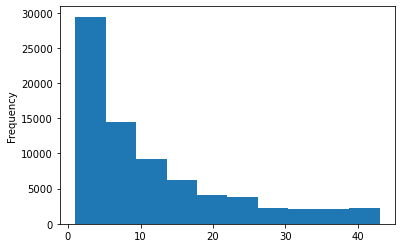

In [166]:
df_modelling_set_y1['no_Claims'].plot.hist()

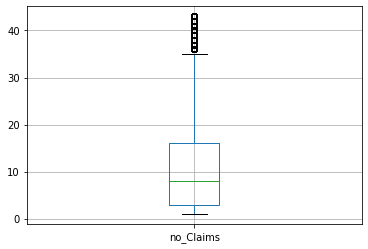

In [167]:
df_modelling_set_y1.boxplot(column = ['no_Claims'])

## B. Claims per Member in Year 2

The distribution of claims in Year 2 looks **very similar** to that of Year 1. It's still a long-tailed distribution with basically the same parameters:
- Half of the claimants make less than 8 claims
- Again, around 35% of the claiming members make at least 12 claims per year, which means at least 1 claim every month

--> Distribution of claims per member stays largely the same, indicating that there has been no change in both general society health conditions as well as claim procedures for these 2 years.

In [177]:
df_modelling_set_y2 = df_modelling_set[df_modelling_set['Year'] == 'Y2']

In [178]:
df_modelling_set_y2['no_Claims'].describe()

count    71435.000000
mean        12.583076
std         11.832364
min          1.000000
25%          4.000000
50%          8.000000
75%         17.000000
max         43.000000
Name: no_Claims, dtype: float64

In [179]:
d = dict(df_modelling_set_y2['no_Claims'].value_counts())

total = df_modelling_set_y2['no_Claims'].count()

for key in d:
    d[key] = [d[key], d[key]/total*100]

df_nc_value_distribution_y2 = pd.DataFrame.from_dict(d, orient='index')
df_nc_value_distribution_y2.columns = ['count', 'percentage']
df_nc_value_distribution_y2.sort_index()

,count,percentage
1,5814,8.138868
2,5426,7.595716
3,5269,7.375936
4,4822,6.750192
5,4337,6.071254
6,3931,5.502905
7,3475,4.864562
8,3098,4.336810
9,2842,3.978442
10,2577,3.607475


In [180]:
df_nc_value_distribution_y2[11:]['percentage'].sum()

35.82977532022118

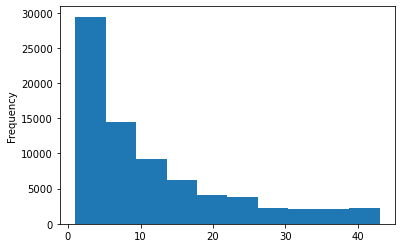

In [181]:
df_modelling_set_y1['no_Claims'].plot.hist()

## C. Changes in Claims per Member from Year 1 to Year 2

Comparing Year 1 and Year 2 Claim per Member data, we spot an alarming sign: the number of those who make large number of claims (43+) has increases dramatically. This is abnormal and requires further investigation.

In [187]:
df_nc_value_distribution_both_years = df_nc_value_distribution_y1.merge(df_nc_value_distribution_y2, left_index = True, right_index = True, suffixes=('_Y1', '_Y2'))

In [191]:
df_nc_value_distribution_both_years = df_nc_value_distribution_both_years.sort_index()
df_nc_value_distribution_both_years

,count_Y1,percentage_Y1,count_Y2,percentage_Y2
1,7011,9.220390,5814,8.138868
2,6328,8.322155,5426,7.595716
3,5918,7.782951,5269,7.375936
4,5428,7.138536,4822,6.750192
5,4764,6.265288,4337,6.071254
6,4349,5.719509,3931,5.502905
7,3862,5.079039,3475,4.864562
8,3234,4.253137,3098,4.336810
9,3061,4.025619,2842,3.978442
10,2646,3.479839,2577,3.607475


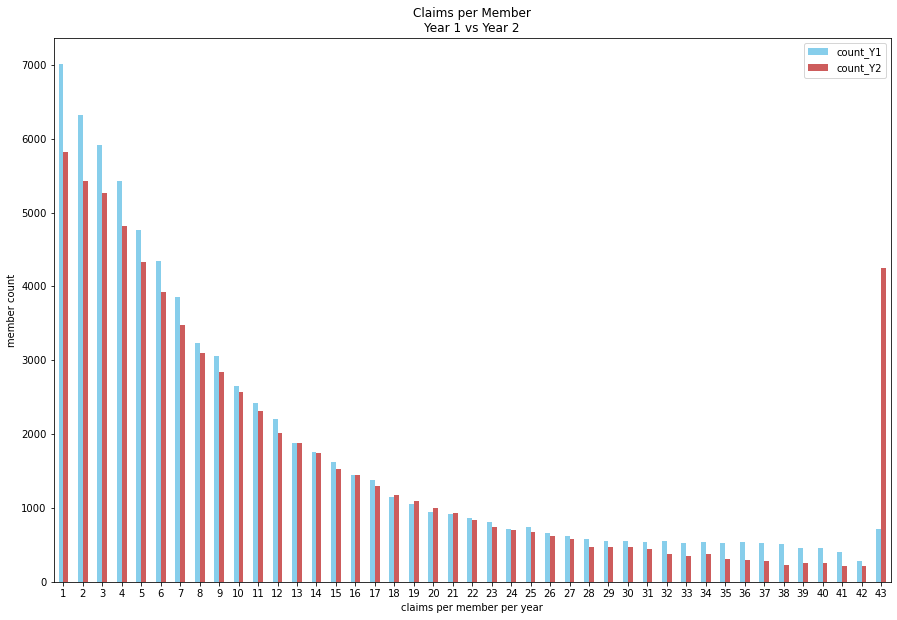

In [200]:
plt.rcParams['figure.figsize'] = [15, 10]

ax = df_nc_value_distribution_both_years[['count_Y1', 'count_Y2']].plot.bar(color=["SkyBlue","IndianRed"], rot=0, title="Claims per Member\nYear 1 vs Year 2")
ax.set_xlabel("claims per member per year")
ax.set_ylabel("member count")
plt.show()